# Assignment 8: KNN Assignment

Import the necessary modules for this asignment

In [128]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from scipy.stats import zscore

from IPython.display import Markdown as md

%matplotlib inline

## Step 1:Read the column description and ensure you understand each attribute well

### Read in the csv file

In [3]:
address = 'C:\\Users\\Charbel\\Desktop\\Udemy\\2021 Data Science - MachineLearning Project Deployment Mastery\\Bank_Personal_Loan_Modelling.csv'

loan_df = pd.read_csv(address)

loan_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


The dataset has 5000 entries used for the study. Assumptions about the attributes in the dataset are listed below.

Age = Client Age <br>
Experience = Years of work experience <br>
Income = Client income in the thousands  <br>
Zip Code = Current residential zip code  <br>
Family = Size of family including client  <br>
CCAvg = Average Credit Card charges per month  <br>
Education =
<pre>1) HS Graduate <br>2) Bachelor's Degree <br>3) Post-Graduate Degree  <br></pre>
Mortgage =  Balance of current mortgage with the bank <br>
Personal Loan = Purchased a loan previously through the bank <span style="color:red">($Target$)</span><br>
Securities Account = Already has an account with the bank <br>
CD Account = Already has a CD through the bank <br>
Online = Does online banking <br>
Credit Card = Has a Credit Card through the bank <br>

## Step 2:Study the data distribution in each attribute, share your findings

In [4]:
loan_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


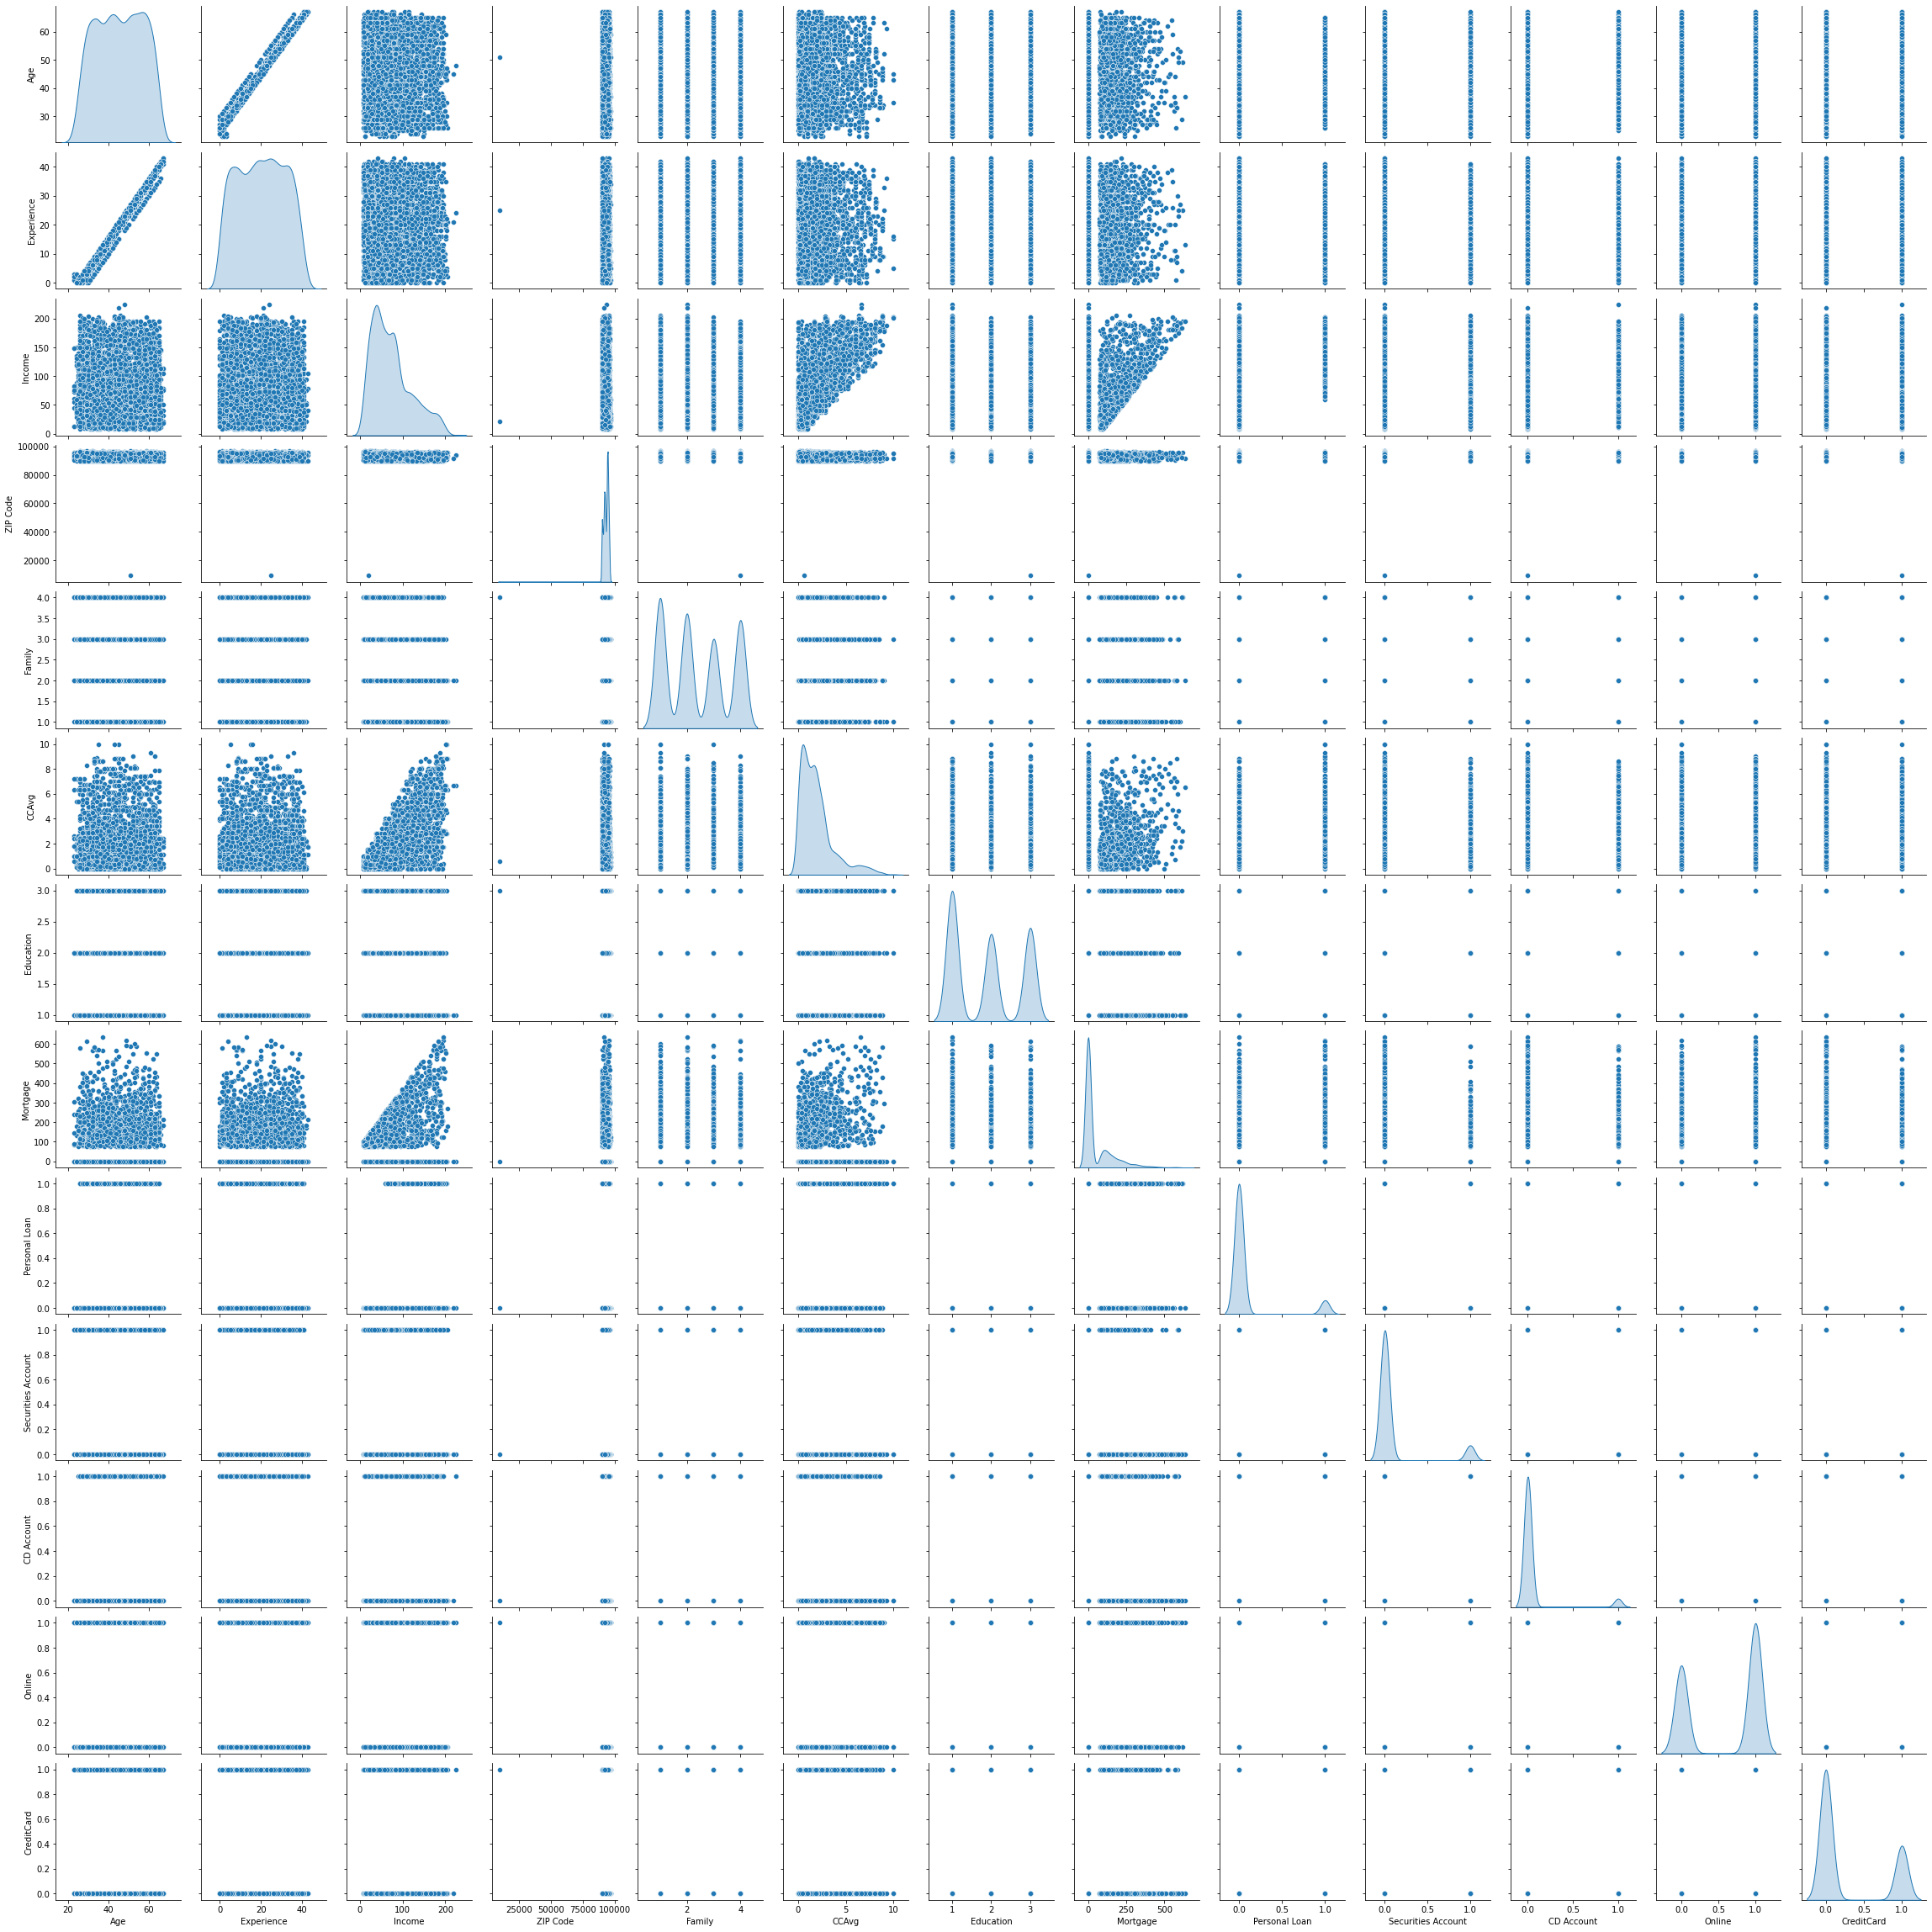

In [41]:
sb.pairplot(loan_df.iloc[:, 1:], diag_kind = 'kde') # excluding the ID attribute since it doesn't impact the prediction


The <b><u>Age</u></b> attribute has a normal distribution. The mean age is 45.3 and the median age is 45 per the describe function<br>

The <b><u>Experience</u></b> attribute is also normally distributed. The mean is 20.1 years while the median is 20 years. Also the describe function shows that there is a minimum value of -3 years. I will correct this with the assumption that the negative values can be replaced with the absolute value.

<b><u>Income</u></b> of the target group is skewed positively. The mean income is nearly 74K. However, the maximum income is 224K.

The <b><u>Zip Code</u></b> is a nominal value and does not appear to show a trend with purchasing a loan.

<b><u>Family Size</u></b> and <b><u>Education</u></b> are both Ordinal variables and do not appear to show any relationship to the purchase of a loan.

The <b><u>CCAvg</u></b> shows correlation to the income. It is also positively skewed with a mean of 1.9K and the maximum is 10K

<b><u>Securities, CD, Credit Card</u></b> and <b><u>Online Banking</u></b> are all binary categorical values

## Step 3:Get the target column distribution. Your comments

In [12]:
x = list(loan_df['Personal Loan'].value_counts())
x

[4520, 480]

In [130]:
x_perc = x[1]/(x[0]+x[1])*100

md('{} of the {} bank clients have purchased loans in the past. This makes the percentage of clients that have purchased the loan previously is {}%'. format(x[1],len(loan_df),x_perc))

480 of the 5000 bank clients have purchased loans in the past. This makes the percentage of clients that have purchased the loan previously is 9.6%

## Step 4:Split the data into training and test set in the ratio of 70:30 respectively

In [16]:
loan_df2 = loan_df

loan_df2['Experience'] = abs(loan_df2['Experience']) # Correct for the negative values for the negative experience

I will now define the X and Y variables and create my train/test datasets.

In [44]:
X = loan_df2.drop(['ID', 'Personal Loan'], axis = 1) # Dropping ID from the attributes since it does not influence the predictability of the model
Y = loan_df2['Personal Loan']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [136]:
print("{}% data is in training set".format((len(x_train)/len(loan_df2)) * 100))
print("{}% data is in test set".format((len(x_test)/len(loan_df2)) * 100))

70.0% data is in training set
30.0% data is in test set


## Step 5:Use different classification models (Logistic, K-NN and Naïve Bayes) to predict the likelihood of a customer buying personal loans
And
## Step 6:Print the confusion matrix for all the above models

#### Logistic Regression Model

Starting with Logistic Regression, I run my model and create the confusion matrix. I conclude with a classification report of the results to understand gaps in the model. The results from the classification report will be used in the conclusion of the assignment

In [46]:
log_model = LogisticRegression(solver='liblinear')
log_model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [47]:
y_predict = log_model.predict(x_test)

0.9073333333333333


<AxesSubplot:>

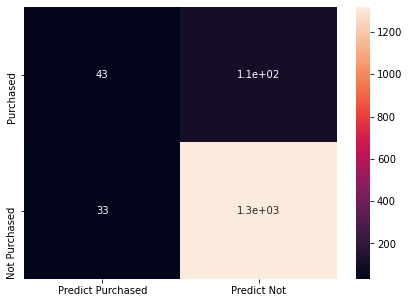

In [48]:
model_score = log_model.score(x_test, y_test)
print(model_score)

cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

log_cm = pd.DataFrame(cm, index = [i for i in ["Purchased","Not Purchased"]], 
                         columns = [i for i in ["Predict Purchased","Predict Not"]])
plt.figure(figsize = (7,5))
sb.heatmap(log_cm, annot=True)

In [138]:
print("Classification Report")
print(metrics.classification_report(y_test, y_predict, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.57      0.29      0.38       149
           0       0.93      0.98      0.95      1351

    accuracy                           0.91      1500
   macro avg       0.75      0.63      0.67      1500
weighted avg       0.89      0.91      0.89      1500



#### Naive Baye's Classifier Model

Next is the Naive Baye's Classifier, I run my model and create the confusion matrix. I conclude with a classification report of the results to understand gaps in the model. The results from the classification report will be used in the conclusion of the assignment

In [50]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

GaussianNB()

In [51]:
y_predict_nb = nb_model.predict(x_test)

0.884


<AxesSubplot:>

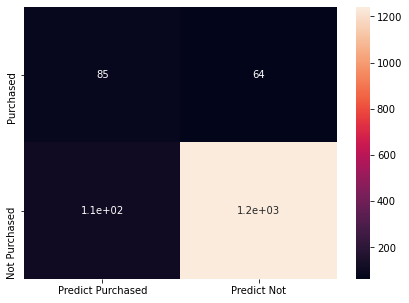

In [52]:
model_score_nb = nb_model.score(x_test, y_test)
print(model_score_nb)

cm=metrics.confusion_matrix(y_test, y_predict_nb, labels=[1, 0])

nb_cm = pd.DataFrame(cm, index = [i for i in ["Purchased","Not Purchased"]], 
                         columns = [i for i in ["Predict Purchased","Predict Not"]])
plt.figure(figsize = (7,5))
sb.heatmap(nb_cm, annot=True)

In [53]:
print("Classification Report")
print(metrics.classification_report(y_test, y_predict_nb, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.44      0.57      0.49       149
           0       0.95      0.92      0.93      1351

    accuracy                           0.88      1500
   macro avg       0.69      0.74      0.71      1500
weighted avg       0.90      0.88      0.89      1500



#### K-Nearest Neighbors Model

Finally I conclude with the K-Nearest Neighbors Model. I run my model and create the confusion matrix. I conclude with a classification report of the results to understand gaps in the model. The results from the classification report will be used in the conclusion of the assignment

In [54]:
y_train.dtypes

dtype('int64')

Instead of converting the y_train data to a 'category' datatype, I decide to leave it as an integer.

In [57]:
XScaled = X.apply(zscore)
XScaled.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,2.478018e-17,1.001421e-16,1.939449e-16,1.513445e-15,7.850609e-16,-2.078338e-17,-6.315837e-16,2.810197e-16,5.092149e-16,4.426903e-16,2.986500e-16,-3.697931e-16
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-1.948906e+00,-1.764019e+00,-1.428969e+00,-3.951919e+01,-1.216855e+00,-1.108987e+00,-1.049078e+00,-5.555239e-01,-3.414233e-01,-2.535403e-01,-1.216618e+00,-6.453143e-01
25%,-9.019702e-01,-8.879059e-01,-7.554825e-01,-5.851619e-01,-1.216855e+00,-7.084116e-01,-1.049078e+00,-5.555239e-01,-3.414233e-01,-2.535403e-01,-1.216618e+00,-6.453143e-01
50%,-2.952359e-02,-1.179249e-02,-2.123482e-01,1.340930e-01,-3.454321e-01,-2.506106e-01,1.417029e-01,-5.555239e-01,-3.414233e-01,-2.535403e-01,8.219509e-01,-6.453143e-01
75%,8.429230e-01,8.643209e-01,5.263146e-01,6.860245e-01,5.259909e-01,3.216407e-01,1.332484e+00,4.375576e-01,-3.414233e-01,-2.535403e-01,8.219509e-01,1.549632e+00
max,1.889859e+00,2.003268e+00,3.263712e+00,1.648959e+00,1.397414e+00,4.613525e+00,1.332484e+00,5.688108e+00,2.928915e+00,3.944146e+00,8.219509e-01,1.549632e+00


In [58]:
XScaled_df=pd.DataFrame(XScaled)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(XScaled_df, Y, test_size=0.30, random_state=1)

Since the accuracy of the model is dependent of the value for k, it's necessary to find the optimal value for k that provides the best score for the model

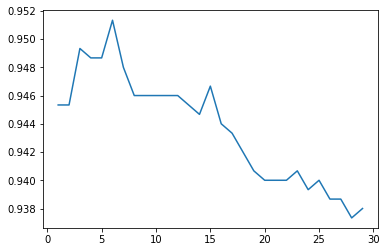

In [64]:
# Set up a for loop to create an array of scores that will be plotted versus a k value

scores =[]
for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors = k, weights = 'distance' )
    knn_model.fit(X_train, y_train)
    scores.append(knn_model.score(X_test, y_test))
    
plt.plot(range(1,30),scores)

From the plot, it appears that the most optimal value for k will be 6. The model will be run with a k value of 6. The confusion matrix and classification report will be displayed below. 

In [65]:
knn_model = KNeighborsClassifier(n_neighbors= 6 , weights = 'distance' )
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, weights='distance')

In [67]:
predicted_labels = knn_model.predict(X_test)
knn_model.score(X_test, y_test)

0.9513333333333334

0.9513333333333334


<AxesSubplot:>

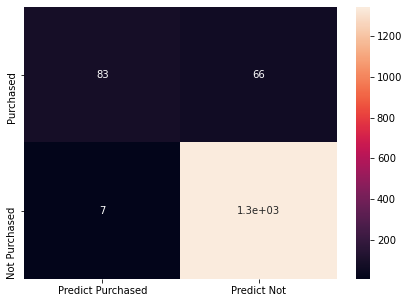

In [70]:
y_predict_knn = knn_model.predict(X_test)

model_score_knn = knn_model.score(X_test, y_test)
print(model_score_knn)

cm=metrics.confusion_matrix(y_test, y_predict_knn, labels=[1, 0])

knn_cm = pd.DataFrame(cm, index = [i for i in ["Purchased","Not Purchased"]], 
                         columns = [i for i in ["Predict Purchased","Predict Not"]])
plt.figure(figsize = (7,5))
sb.heatmap(knn_cm, annot=True)

In [88]:
print("Classification Report")
print(metrics.classification_report(y_test, y_predict_knn, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.92      0.56      0.69       149
           0       0.95      0.99      0.97      1351

    accuracy                           0.95      1500
   macro avg       0.94      0.78      0.83      1500
weighted avg       0.95      0.95      0.95      1500



The classification report shows the various scores for the model. However, these metrics should be compared side by side for all 3 models. This will show which model is the best for prediction. 

In [89]:
log_class_rep = metrics.classification_report(y_test, y_predict, labels=[1, 0])
log_split = log_class_rep.split(' ')
log_num = []
for i in range(len(log_split)):
    if log_split[i] != '':
        log_num.append(log_split[i])

nb_class_rep = metrics.classification_report(y_test, y_predict_nb, labels=[1, 0])
nb_split = nb_class_rep.split(' ')
nb_num = []
for i in range(len(nb_split)):
    if nb_split[i] != '':
        nb_num.append(nb_split[i])

knn_class_rep = metrics.classification_report(y_test, y_predict_knn, labels=[1, 0])
knn_split = knn_class_rep.split(' ')
knn_num = []
for i in range(len(knn_split)):
    if knn_split[i] != '':
        knn_num.append(knn_split[i])


The goal now is to tabulate all the results side-by-side to compare the precision, recall and accuracy of the three different models.

In [103]:
df = pd.DataFrame(log_num)
df['Naive Baye\'s'] = nb_num
df['K-Nearest Neighbor'] = knn_num
df.rename(columns = {0:'Logistic Regression'}, inplace = True)
df.drop([0,1,2,3,4,8,9,13,14,16], axis = 0, inplace = True)
df.drop([17, 18, 19, 20, 21, 22, 23, 24,25,26,27], inplace = True)
df.rename(index = {5:'pos_prec', 6:'pos_recall', 7:'pos_F1', 10:'neg_prec', 11:'neg_recall', 12:'neg_F1', 15:'Accuracy'}, inplace = True)
df

,Logistic Regression,Naive Baye's,K-Nearest Neighbor
pos_prec,0.57,0.44,0.92
pos_recall,0.29,0.57,0.56
pos_F1,0.38,0.49,0.69
neg_prec,0.93,0.95,0.95
neg_recall,0.98,0.92,0.99
neg_F1,0.95,0.93,0.97
Accuracy,0.91,0.88,0.95


## Step 7:Give your reasoning on which is the best model in this case and why it performs better?

In this assignment, 3 models were compared using the same training and test datasets to predict the likelihood of a client purchasing a loan from the bank. The three models run were the Logistic Regression Model, Naive Baye's Classifier and the K-Nearest Neighbors (KNN) Model.

In correctly predicting if a client would purchase a loan, the the KNN Model showed the best fit with a precision of 92%. Logistic Regression and Naive Baye's showed precision of 57% and 44% respectively. The recall (correct identification) for the Naive Baye's and KNN models were comparable with 57% and 56% respectively. The Logistic Regression Model was only 29%. The F1 score of the KNN Model was the best out of the 3 with 69%. Logistic Regression and Naive Baye's had F1 scores of 38% and 49% respectively.

In correctly predicting if a client would not purchase a loan, all 3 models showed precision, recall and F1 scores above 90%.

The overall accuracy of the 3 models shows that the KNN model had the best accuracy at 95%, followed by Logistic Regression at 91% and Naive Baye's at 88%.

From these results it's safe to say that the KNN Model performs the best out of the 3 models. This is likely due to the fact that the model uses association with entries of similar attributes in order to make its prediction.